In [46]:
import sys
sys.path.append('/workspace/analysis')

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, correlate
from scipy import stats
import rosbag_loader

%matplotlib inline
plt.rcParams['figure.figsize'] = (14, 8)

## Configuration

In [47]:
# Select bag file - choose one with high speed motion for best results
BAG_PATH = '/workspace/rosbags/2025-12-17-16-02-22.bag'

# Filtering thresholds
MIN_INTENSITY = 2.0  # Ignore weak radar returns (clutter)
MIN_RANGE = 0.5       # Ignore very close points (m)
MIN_POINTS_PER_FRAME = 5  # Need enough points for overdetermined system

# Signal processing parameters
IMU_HIGHPASS_CUTOFF = 0.5  # Hz - removes integration drift
RADAR_LOWPASS_CUTOFF = 5.0  # Hz - smooths radar velocity estimate

## Step 1: Load Data

In [48]:
print(f"Loading {BAG_PATH}...\n")
data = rosbag_loader.load_bag_topics(BAG_PATH, verbose=True)

print(f"\n=== Loaded Data Summary ===")
print(f"IMU samples: {len(data.imu_data)}")
print(f"Radar velocity frames: {len(data.radar_velocity)}")
print(f"Duration: {data.duration:.2f} s")

Loading /workspace/rosbags/2025-12-17-16-02-22.bag...




Loading rosbag: 2025-12-17-16-02-22.bag
Duration: 48.59s
  Loading /mocap/angrybird2/pose...
  Loading /mocap/angrybird2/accel...
  Loading /angrybird2/agiros_pilot/state...
  Loading /angrybird2/agiros_pilot/odometry...
  Loading /angrybird2/imu...
  Loading /ti_mmwave/radar_scan_pcl_0...
  Loading /mmWaveDataHdl/RScanVelocity...
  Done!


=== Loaded Data Summary ===
IMU samples: 48437
Radar velocity frames: 1396
Duration: 48.59 s


## Step 2: Ego-Velocity Estimation via Least Squares

For each radar frame with $N$ points, we solve:

$$\mathbf{H} \vec{v}_{body} = \vec{z}$$

where:
- $\mathbf{H} = [\hat{r}_1, \hat{r}_2, ..., \hat{r}_N]^T$ are unit direction vectors
- $\vec{z} = [v_{rad,1}, v_{rad,2}, ..., v_{rad,N}]^T$ are measured radial velocities
- $\vec{v}_{body}$ is the 3D ego-velocity we solve for

This is an **overdetermined system** solved via: $\vec{v}_{body} = (\mathbf{H}^T\mathbf{H})^{-1}\mathbf{H}^T\vec{z}$

In [49]:
def solve_ego_velocity_3d(positions, velocities, intensities):
    """
    Solve for 3D body velocity vector using Least Squares.
    
    Args:
        positions: Nx3 array of [x, y, z] in meters
        velocities: N array of radial velocities in m/s
        intensities: N array of return intensities
        
    Returns:
        v_body: 3D velocity vector [vx, vy, vz] or None if insufficient points
    """
    H = []
    z = []
    
    for i in range(len(positions)):
        x, y, z_coord = positions[i]
        v_rad = velocities[i]
        intensity = intensities[i]
        
        # Compute range
        r = np.sqrt(x**2 + y**2 + z_coord**2)
        
        # Filter: ignore weak points or near-zero range (clutter)
        if intensity < MIN_INTENSITY or r < MIN_RANGE:
            continue
        
        # Unit direction vector pointing to target
        dir_vec = np.array([x/r, y/r, z_coord/r])
        
        H.append(dir_vec)
        z.append(v_rad)
    
    # Need enough points for overdetermined system
    if len(z) < MIN_POINTS_PER_FRAME:
        return None
    
    H = np.array(H)
    z = np.array(z)
    
    try:
        # Least squares solution: v_body = (H^T H)^-1 H^T z
        v_body, residuals, rank, s = np.linalg.lstsq(H, z, rcond=None)
        
        # Sign convention: radar measures closing velocity as negative
        # Forward flight (+x) sees static objects closing (negative v_rad)
        # So we invert to get drone velocity in body frame
        return -v_body
        
    except np.linalg.LinAlgError:
        return None


# Process all radar frames
radar_times = []
radar_velocities_x = []
radar_velocities_3d = []  # Full 3D velocity vectors
radar_cpu_cycles = []
radar_frame_numbers = []
radar_num_points_used = []

print("Estimating ego-velocity from radar point clouds...")
for frame in data.radar_velocity:
    if frame.velocities is None or frame.intensities is None:
        continue
    
    v_body = solve_ego_velocity_3d(
        frame.positions,
        frame.velocities,
        frame.intensities
    )
    
    if v_body is not None:
        radar_times.append(frame.timestamp)
        radar_velocities_x.append(v_body[0])  # X-axis velocity (forward)
        radar_velocities_3d.append(v_body)
        
        # Store CPU cycles and frame numbers for time calibration
        if frame.time_cpu_cycles is not None and len(frame.time_cpu_cycles) > 0:
            radar_cpu_cycles.append(frame.time_cpu_cycles[0])
        else:
            radar_cpu_cycles.append(0)
            
        if frame.frame_number is not None and len(frame.frame_number) > 0:
            radar_frame_numbers.append(frame.frame_number[0])
        else:
            radar_frame_numbers.append(0)
        
        # Count how many points passed the filter
        num_used = sum(1 for i in range(len(frame.positions))
                      if frame.intensities[i] >= MIN_INTENSITY and
                      np.linalg.norm(frame.positions[i]) >= MIN_RANGE)
        radar_num_points_used.append(num_used)

radar_times = np.array(radar_times)
radar_velocities_x = np.array(radar_velocities_x)
radar_velocities_3d = np.array(radar_velocities_3d)
radar_cpu_cycles = np.array(radar_cpu_cycles)

print(f"Processed {len(radar_times)} radar frames")
print(f"Velocity X range: [{np.min(radar_velocities_x):.2f}, {np.max(radar_velocities_x):.2f}] m/s")
print(f"Mean points used per frame: {np.mean(radar_num_points_used):.1f}")

Estimating ego-velocity from radar point clouds...
Processed 721 radar frames
Velocity X range: [-6.30, 5.70] m/s
Mean points used per frame: 6.4


## Step 3: IMU Integration to Velocity

1. Remove gravity bias (calculate mean during stationary periods)
2. Integrate $a_x(t)$ to get $v_x(t)$
3. Apply high-pass filter to remove integration drift

In [50]:
# Extract IMU data
imu_times = np.array([imu.timestamp for imu in data.imu_data])
imu_accel_x = np.array([imu.linear_acceleration[0] for imu in data.imu_data])
imu_accel_y = np.array([imu.linear_acceleration[1] for imu in data.imu_data])
imu_accel_z = np.array([imu.linear_acceleration[2] for imu in data.imu_data])

print(f"IMU samples: {len(imu_times)}")
print(f"IMU sample rate: {len(imu_times) / (imu_times[-1] - imu_times[0]):.1f} Hz")

# Step 1: Bias removal
# Assuming symmetric pumping motion or averaging over full trajectory
accel_x_bias = np.mean(imu_accel_x)
imu_accel_x_unbiased = imu_accel_x - accel_x_bias

print(f"Accel X bias (gravity component): {accel_x_bias:.3f} m/s²")

# Step 2: Integrate acceleration to velocity
dt_imu = np.diff(imu_times)
dt_imu = np.insert(dt_imu, 0, dt_imu[0])  # Pad first element
imu_vel_x = np.cumsum(imu_accel_x_unbiased * dt_imu)

print(f"Raw integrated velocity range: [{np.min(imu_vel_x):.2f}, {np.max(imu_vel_x):.2f}] m/s")

# Step 3: High-pass filter to remove integration drift
fs_imu = 1.0 / np.mean(dt_imu)
b, a = butter(2, IMU_HIGHPASS_CUTOFF, btype='high', fs=fs_imu)
imu_vel_x_filtered = filtfilt(b, a, imu_vel_x)

print(f"Filtered IMU velocity range: [{np.min(imu_vel_x_filtered):.2f}, {np.max(imu_vel_x_filtered):.2f}] m/s")
print(f"High-pass cutoff: {IMU_HIGHPASS_CUTOFF} Hz")

IMU samples: 48437
IMU sample rate: 996.9 Hz
Accel X bias (gravity component): 0.809 m/s²
Raw integrated velocity range: [-14.62, 1.18] m/s
Filtered IMU velocity range: [-0.78, 0.71] m/s
High-pass cutoff: 0.5 Hz


## Step 4: Radar Signal Filtering and Interpolation

In [51]:
# Low-pass filter radar velocity to remove measurement noise
fs_radar = len(radar_times) / (radar_times[-1] - radar_times[0])
print(f"Radar sample rate: {fs_radar:.1f} Hz")

b_radar, a_radar = butter(2, RADAR_LOWPASS_CUTOFF, btype='low', fs=fs_radar)
radar_vel_x_filtered = filtfilt(b_radar, a_radar, radar_velocities_x)

print(f"Filtered radar velocity range: [{np.min(radar_vel_x_filtered):.2f}, {np.max(radar_vel_x_filtered):.2f}] m/s")

# Interpolate radar onto IMU time grid
radar_vel_x_interp = np.interp(imu_times, radar_times, radar_vel_x_filtered)

print(f"Interpolated radar signal to {len(radar_vel_x_interp)} samples")

Radar sample rate: 15.7 Hz
Filtered radar velocity range: [-4.50, 3.67] m/s
Interpolated radar signal to 48437 samples


## Step 5: Cross-Correlation to Find Time Lag

Find the time offset $\tau$ that maximizes correlation between IMU and radar velocity:

$$\tau^* = \arg\max_\tau \int v_{IMU}(t) \cdot v_{radar}(t + \tau) \, dt$$


=== CROSS-CORRELATION RESULTS ===
Calculated time lag: 841.58 ms
(Positive lag means IMU leads Radar, i.e., Radar is delayed)
Max correlation value: 6.35e+03


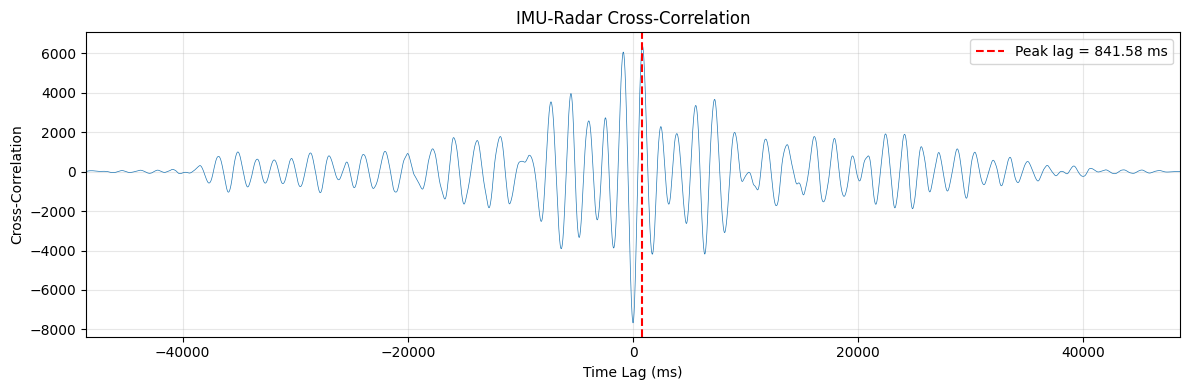

In [52]:
# Cross-correlate to find lag
correlation = correlate(imu_vel_x_filtered, radar_vel_x_interp, mode='full')
lags = np.arange(-len(imu_vel_x_filtered) + 1, len(imu_vel_x_filtered))
lag_times = lags / fs_imu

# Find peak correlation
max_corr_idx = np.argmax(correlation)
time_lag = lag_times[max_corr_idx]
max_corr_value = correlation[max_corr_idx]

print(f"\n=== CROSS-CORRELATION RESULTS ===")
print(f"Calculated time lag: {time_lag*1000:.2f} ms")
print(f"(Positive lag means IMU leads Radar, i.e., Radar is delayed)")
print(f"Max correlation value: {max_corr_value:.2e}")

# Plot cross-correlation
plt.figure(figsize=(12, 4))
plt.plot(lag_times * 1000, correlation, linewidth=0.5)
plt.axvline(time_lag * 1000, color='r', linestyle='--', label=f'Peak lag = {time_lag*1000:.2f} ms')
plt.xlabel('Time Lag (ms)')
plt.ylabel('Cross-Correlation')
plt.title('IMU-Radar Cross-Correlation')
plt.grid(True, alpha=0.3)
plt.legend()
plt.xlim([lag_times[0]*1000, lag_times[-1]*1000])
plt.tight_layout()
plt.show()

## Step 6: Time-Corrected Velocity Comparison

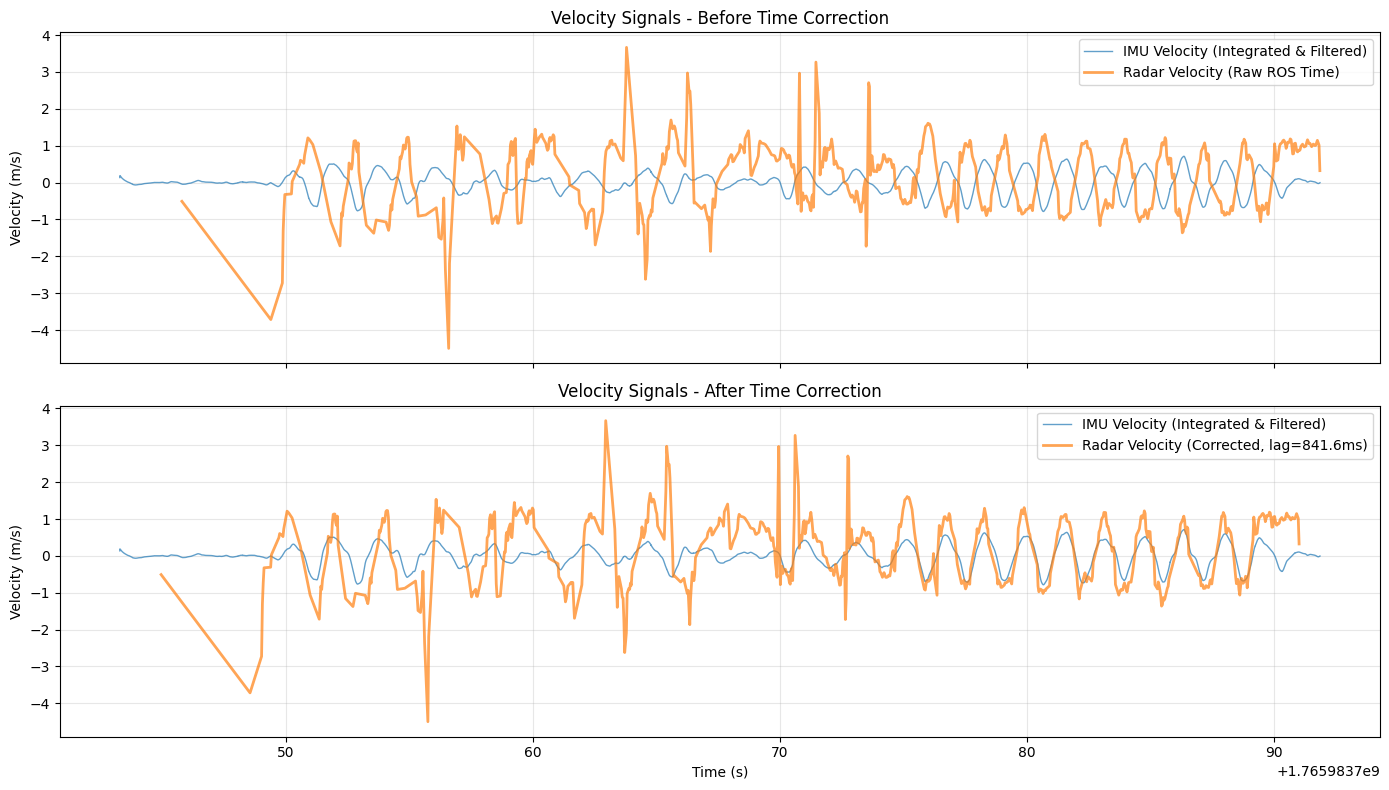

In [53]:
# Apply time correction to radar timestamps
radar_times_corrected = radar_times - time_lag

# Plot velocity signals with and without correction
fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# Raw comparison
axes[0].plot(imu_times, imu_vel_x_filtered, label='IMU Velocity (Integrated & Filtered)', alpha=0.7, linewidth=1)
axes[0].plot(radar_times, radar_vel_x_filtered, label='Radar Velocity (Raw ROS Time)', alpha=0.7, linewidth=2)
axes[0].set_ylabel('Velocity (m/s)')
axes[0].set_title('Velocity Signals - Before Time Correction')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Corrected comparison
axes[1].plot(imu_times, imu_vel_x_filtered, label='IMU Velocity (Integrated & Filtered)', alpha=0.7, linewidth=1)
axes[1].plot(radar_times_corrected, radar_vel_x_filtered, label=f'Radar Velocity (Corrected, lag={time_lag*1000:.1f}ms)', alpha=0.7, linewidth=2)
axes[1].set_xlabel('Time (s)')
axes[1].set_ylabel('Velocity (m/s)')
axes[1].set_title('Velocity Signals - After Time Correction')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Step 7: CPU Cycle to ROS Time Calibration

Fit a linear model to map radar CPU cycles to corrected ROS time:

$$t_{corrected} = \alpha \cdot \text{cpu\_cycles} + \beta$$


=== CPU CYCLE CALIBRATION ===
Linear fit: t_corrected = 1.8385698706e-10 * cpu_cycles + 1765983772.2331
R² value: 0.000408
Estimated clock frequency: 5439.01 MHz

Calibration formula:
  corrected_time = 1.8385698706e-10 * cpu_cycles + 1765983772.2331


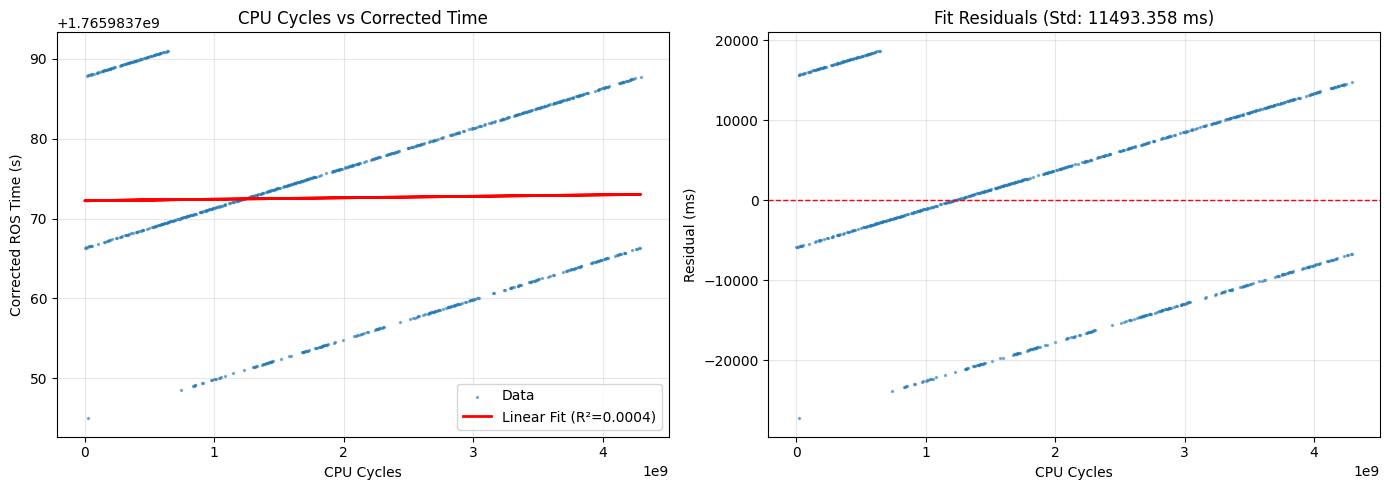

In [54]:
# Filter out zero CPU cycle values (if any)
valid_mask = radar_cpu_cycles > 0
radar_cpu_valid = radar_cpu_cycles[valid_mask]
radar_times_corrected_valid = radar_times_corrected[valid_mask]

if len(radar_cpu_valid) > 10:
    # Linear regression: time = slope * cpu_cycles + intercept
    slope, intercept, r_value, p_value, std_err = stats.linregress(radar_cpu_valid, radar_times_corrected_valid)
    
    # Compute clock frequency
    clock_freq_hz = 1.0 / slope
    clock_freq_mhz = clock_freq_hz / 1e6
    
    print(f"\n=== CPU CYCLE CALIBRATION ===")
    print(f"Linear fit: t_corrected = {slope:.10e} * cpu_cycles + {intercept:.4f}")
    print(f"R² value: {r_value**2:.6f}")
    print(f"Estimated clock frequency: {clock_freq_mhz:.2f} MHz")
    print(f"\nCalibration formula:")
    print(f"  corrected_time = {slope:.10e} * cpu_cycles + {intercept:.4f}")
    
    # Plot CPU cycles vs time
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Scatter plot with fit line
    axes[0].scatter(radar_cpu_valid, radar_times_corrected_valid, s=2, alpha=0.5, label='Data')
    axes[0].plot(radar_cpu_valid, slope*radar_cpu_valid + intercept, 'r-', linewidth=2, label=f'Linear Fit (R²={r_value**2:.4f})')
    axes[0].set_xlabel('CPU Cycles')
    axes[0].set_ylabel('Corrected ROS Time (s)')
    axes[0].set_title('CPU Cycles vs Corrected Time')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Residuals
    residuals = radar_times_corrected_valid - (slope*radar_cpu_valid + intercept)
    axes[1].scatter(radar_cpu_valid, residuals * 1000, s=2, alpha=0.5)  # Convert to ms
    axes[1].axhline(0, color='r', linestyle='--', linewidth=1)
    axes[1].set_xlabel('CPU Cycles')
    axes[1].set_ylabel('Residual (ms)')
    axes[1].set_title(f'Fit Residuals (Std: {np.std(residuals)*1000:.3f} ms)')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
else:
    print("\n⚠️ Insufficient CPU cycle data for calibration")
    print(f"Only {len(radar_cpu_valid)} valid samples available")

## Step 8: 3D Velocity Analysis

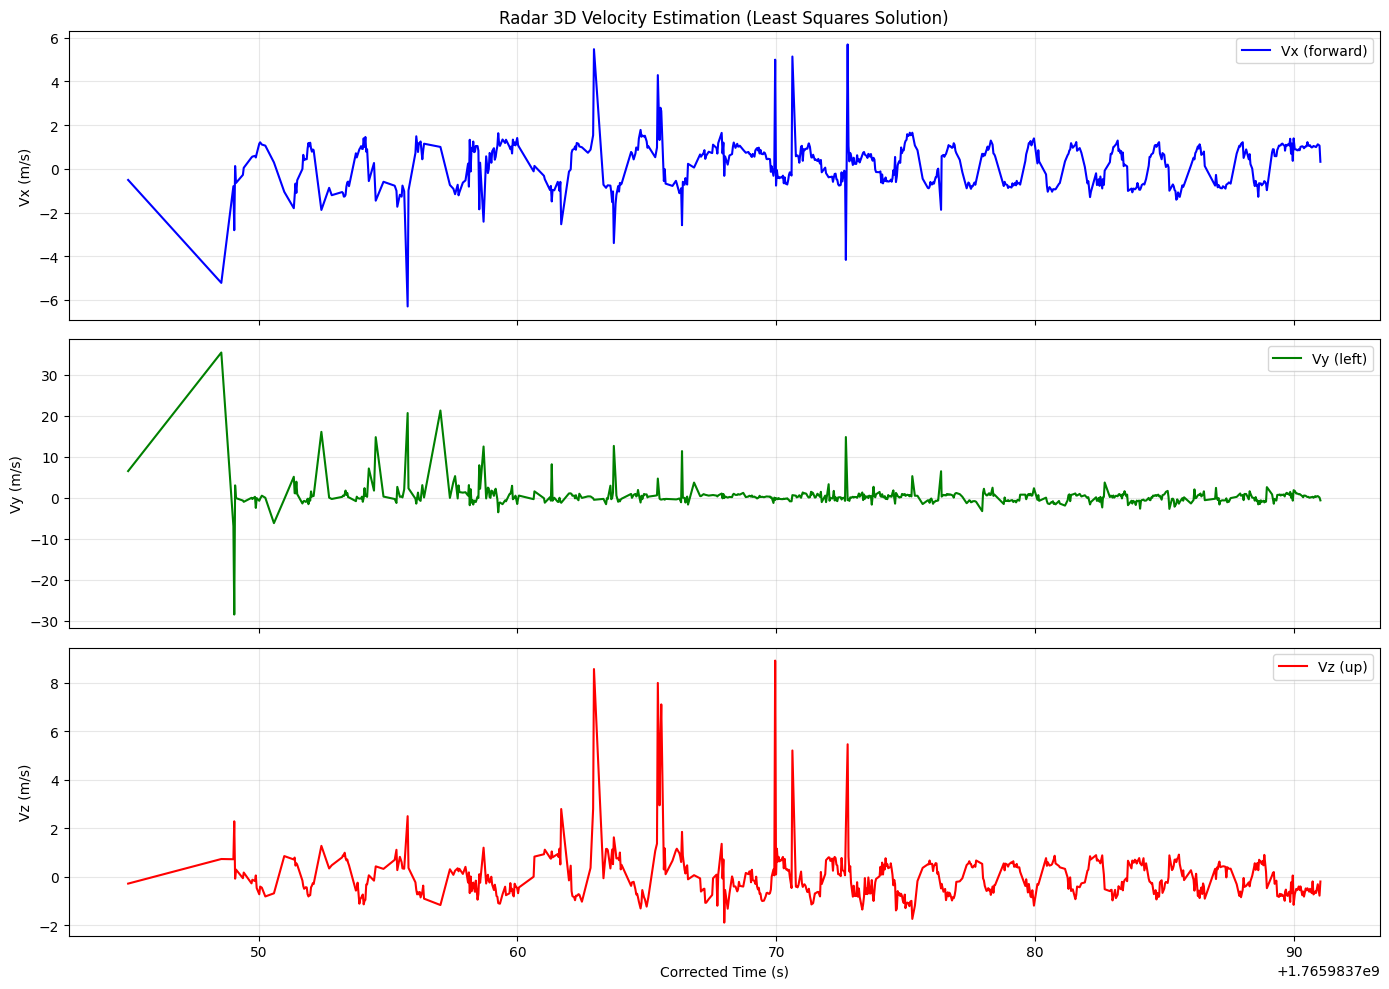


=== 3D Velocity Statistics ===
Vx: mean=0.20, std=1.02 m/s
Vy: mean=0.39, std=2.67 m/s
Vz: mean=-0.03, std=0.97 m/s

Speed: mean=1.72, max=35.87 m/s


In [55]:
# Plot all three components of radar velocity estimate
fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

axes[0].plot(radar_times_corrected, radar_velocities_3d[:, 0], 'b-', linewidth=1.5, label='Vx (forward)')
axes[0].set_ylabel('Vx (m/s)')
axes[0].set_title('Radar 3D Velocity Estimation (Least Squares Solution)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(radar_times_corrected, radar_velocities_3d[:, 1], 'g-', linewidth=1.5, label='Vy (left)')
axes[1].set_ylabel('Vy (m/s)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

axes[2].plot(radar_times_corrected, radar_velocities_3d[:, 2], 'r-', linewidth=1.5, label='Vz (up)')
axes[2].set_xlabel('Corrected Time (s)')
axes[2].set_ylabel('Vz (m/s)')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print statistics
print("\n=== 3D Velocity Statistics ===")
print(f"Vx: mean={np.mean(radar_velocities_3d[:, 0]):.2f}, std={np.std(radar_velocities_3d[:, 0]):.2f} m/s")
print(f"Vy: mean={np.mean(radar_velocities_3d[:, 1]):.2f}, std={np.std(radar_velocities_3d[:, 1]):.2f} m/s")
print(f"Vz: mean={np.mean(radar_velocities_3d[:, 2]):.2f}, std={np.std(radar_velocities_3d[:, 2]):.2f} m/s")
print(f"\nSpeed: mean={np.mean(np.linalg.norm(radar_velocities_3d, axis=1)):.2f}, max={np.max(np.linalg.norm(radar_velocities_3d, axis=1)):.2f} m/s")

## Step 9: Quality Metrics


=== ALIGNMENT QUALITY METRICS ===
Correlation coefficient: 0.3785
RMS error: 1.024 m/s
Time lag: 841.58 ms


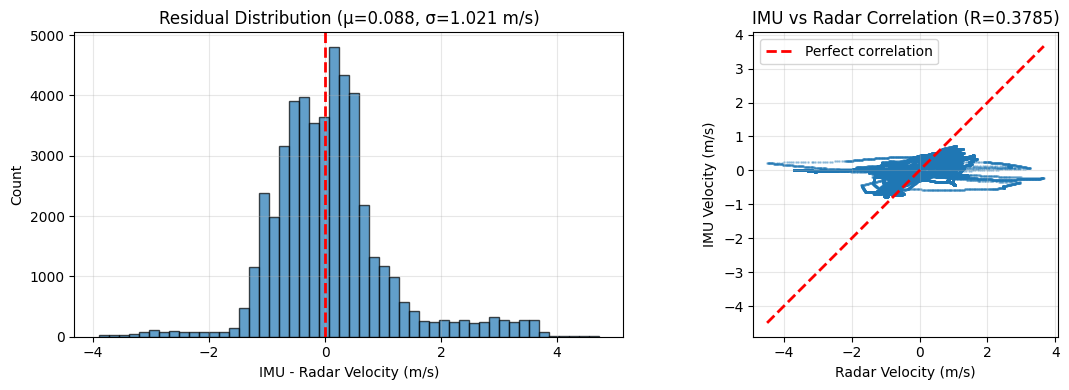

In [56]:
# Correlation coefficient after alignment
radar_vel_aligned_interp = np.interp(imu_times, radar_times_corrected, radar_vel_x_filtered)
correlation_coeff = np.corrcoef(imu_vel_x_filtered, radar_vel_aligned_interp)[0, 1]

# RMS error
rms_error = np.sqrt(np.mean((imu_vel_x_filtered - radar_vel_aligned_interp)**2))

print("\n=== ALIGNMENT QUALITY METRICS ===")
print(f"Correlation coefficient: {correlation_coeff:.4f}")
print(f"RMS error: {rms_error:.3f} m/s")
print(f"Time lag: {time_lag*1000:.2f} ms")

# Plot histogram of residuals
residuals = imu_vel_x_filtered - radar_vel_aligned_interp

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(residuals, bins=50, alpha=0.7, edgecolor='black')
axes[0].axvline(0, color='r', linestyle='--', linewidth=2)
axes[0].set_xlabel('IMU - Radar Velocity (m/s)')
axes[0].set_ylabel('Count')
axes[0].set_title(f'Residual Distribution (μ={np.mean(residuals):.3f}, σ={np.std(residuals):.3f} m/s)')
axes[0].grid(True, alpha=0.3)

axes[1].scatter(radar_vel_aligned_interp, imu_vel_x_filtered, s=1, alpha=0.3)
axes[1].plot([radar_vel_aligned_interp.min(), radar_vel_aligned_interp.max()],
             [radar_vel_aligned_interp.min(), radar_vel_aligned_interp.max()],
             'r--', linewidth=2, label='Perfect correlation')
axes[1].set_xlabel('Radar Velocity (m/s)')
axes[1].set_ylabel('IMU Velocity (m/s)')
axes[1].set_title(f'IMU vs Radar Correlation (R={correlation_coeff:.4f})')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].set_aspect('equal')

plt.tight_layout()
plt.show()

## Summary

This notebook demonstrates:
1. ✅ Proper least-squares ego-velocity estimation (no averaging)
2. ✅ IMU integration with high-pass filtering for drift removal
3. ✅ Cross-correlation for time synchronization
4. ✅ CPU cycle to ROS time calibration
5. ✅ Full 3D velocity estimation

The calculated time lag and calibration parameters can be used to properly synchronize radar and IMU data for sensor fusion applications.